In [11]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from aix360.algorithms.protodash import ProtodashExplainer
from lime.lime_tabular import LimeTabularExplainer
from lime.submodular_pick import SubmodularPick

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def extract_W_multiclass(coef, xs, ys, coo=True):
    W = [{} for _ in xs]
    features = (xs.tocoo().row, xs.tocoo().col) if coo else np.where(xs != None)
    for (r, c) in zip(features[0], features[1]):
        W[r][c] = coef[ys[r]][c]
    return W

def get_feature_importance(W):
    importance = {}
    for ins in W:
        for j in ins:
            importance[j] = importance.get(j, 0.0) + np.abs(ins[j])
    for j in importance:
        importance[j] = np.sqrt(importance[j])
    return importance

def get_used(feature_dict, top=10):
    # only consider top 10 features as used
    values = [(np.abs(v), k) for k, v in feature_dict.items()]
    values.sort(reverse=True)
    return [i for _, i in values[:top]]

def lime_objective(results, W, importance, top=10):
    obj, covered = 0, set()
    for index in results:
        for j in get_used(W[index], top):
            if j not in covered:
                obj += importance[j]
                covered.add(j)
    return obj, covered

def greedy_sp_search_multiclass(results, W, importance, budget, ys, top=10):
    flattened = [index for _class in results for index in _class]
    class_len = list(map(len, results))
    obj, covered = lime_objective(flattened, W, importance, top)
    max_diff, max_index = -1, -1
    for i in range(len(W)):
        if i in flattened or class_len[ys[i]] >= budget[ys[i]]:
            continue
        diff = 0
        for j in get_used(W[i], top):
            if j not in covered:
                diff += importance[j]
        if diff > max_diff:
            max_diff, max_index = diff, i
    return max_index, obj

def gready_sp_multiclass(W, budget, ys, top=10):
    importance = get_feature_importance(W)
    results = [[] for _ in range(np.unique(ys).size)]
    while np.any(list(map(len, results)) < np.array(budget)):
        max_index, current_obj = greedy_sp_search_multiclass(results, W, importance, budget, ys, top)
        if max_index >= 0:
            results[ys[max_index]].append(max_index)
#             print(max_index)
        else:
            break
    return results, current_obj, importance

In [9]:
METRIC = "auc"
WEIGHTS = "uniform"

def get_knn_score(k, data, index, metric=METRIC, weights=WEIGHTS):
    X_train, y_train, X_valid, y_valid = data
    knc = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knc.fit(X_train[index], y_train[index])
    if metric == 'auc':
        probs = knc.predict_proba(X_valid)
        probs = probs[:, 1] if probs.shape[1] > 1 else probs
        score = roc_auc_score(y_valid, probs)
    else:
        score = knc.score(X_valid, y_valid)
    return score

def get_ci(samples, confidence=0.95):
    return 2 * stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)

In [6]:
train_path = 'data/prostatex/train_findings_emb10.pkl'
valid_path = 'data/prostatex/valid_findings_emb10.pkl'
f_train, _, y_train, X_train, _ = pickle.load(open(train_path, "rb"))
f_valid, _, y_valid, X_valid, _ = pickle.load(open(valid_path, "rb"))
data = X_train, y_train, X_valid, y_valid
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
print(lr.score(X_valid, y_valid))
coef = np.vstack([lr.coef_, -lr.coef_])
W = extract_W_multiclass(coef, X_train, y_train, coo=False)

k_range = [3, 5, 7, 9]
m_range = list(range(10, len(X_train), 10))
f_scores = []
for k in k_range:
    score = get_knn_score(k, data, list(range(len(data[0]))))
    f_scores.append(score)
f_scores = np.array(f_scores)
f_scores


0.7777777777777778


array([0.72813411, 0.72813411, 0.76895044, 0.83309038])

In [7]:
p_idss = {}
# s_idss = {}

X_train, y_train, X_valid, y_valid = data
for m in m_range:
    protodash = ProtodashExplainer()
    _, index, _ = protodash.explain(X_train, X_train, m=m)
    p_idss[m] = index
    # budget = [(m+1)//2, m//2]
    # sp_results, current_obj, importance = gready_sp_multiclass(W, budget, y_train, 100)
    # index = sp_results[0] + sp_results[1]
    # s_idss[m] = index

In [8]:
pickle.dump(p_idss, open("p_index.emb10.pkl", "wb"))
p_idss = pickle.load(open("p_index.emb10.pkl", "rb"))
p_scores = []
for k in k_range:
    for m in m_range:
        p_scores.append(get_knn_score(k, data, p_idss[m]))
p_scores = np.array(p_scores).reshape(len(k_range), len(m_range))

In [12]:
# n_trials = 100
# r_scores = []
# np.random.seed(42)
# for k in k_range:
#     for m in m_range:
#         scores = []
#         for i in range(n_trials):
#             index = np.random.choice(range(len(X_train)), m, replace=False)
#             scores.append(get_knn_score(k, data, index))
#         r_scores.append((scores))
# r_scores = np.array(r_scores).reshape(len(k_range), len(m_range), n_trials)
# pickle.dump(r_scores, open("rscores.{}.emb10.pkl".format(WEIGHTS), "wb"))
r_scores = pickle.load(open("rscores.{}.emb10.pkl".format(WEIGHTS), "rb"))
r_means = r_scores.mean(axis=-1)
r_confs = np.array([get_ci(r_scores[k][m]) for m in range(len(m_range)) for k in range(len(k_range))])

Text(0.5, 0.98, 'AUC, KNN weights uniform')

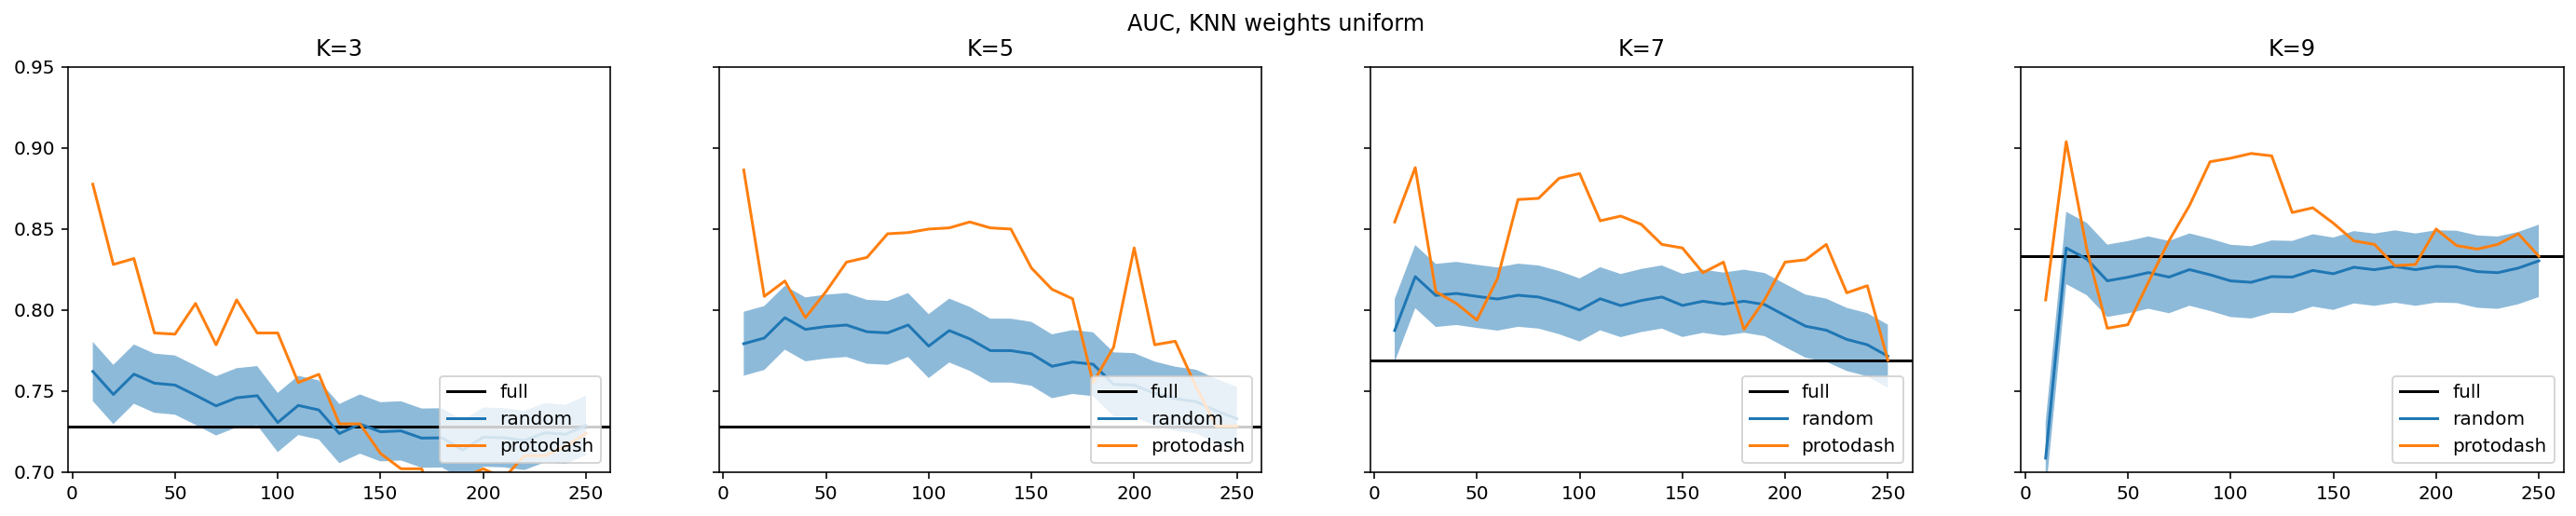

In [13]:
fig, ax = plt.subplots(1, len(k_range), figsize=(24, 4), sharey=True)
for k in range(len(k_range)):
    ax[k].axhline(f_scores[k], c='black')
    ax[k].plot(m_range, r_means[k])
    ax[k].fill_between(m_range, r_means[k] + r_confs[k] / 2, r_means[k] - r_confs[k] / 2, alpha=0.5)
    ax[k].plot(m_range, p_scores[k])
    # ax[k].plot(m_range, s_scores[k])
    ax[k].set_ylim(0.7, 0.95)
    ax[k].legend(['full', 'random', 'protodash'], loc='lower right')
    ax[k].set_title('K={}'.format(k_range[k]))
fig.suptitle('AUC, KNN weights ' + WEIGHTS)

In [ ]:
# p_scores = []
# s_scores = []
# for k in k_range:
#     for m in m_range:
#         p_scores.append(get_knn_score(k, data, p_idss[m]))
#         s_scores.append(get_knn_score(k, data, s_idss[m]))
# p_scores = np.array(p_scores).reshape(len(k_range), len(m_range))
# s_scores = np.array(s_scores).reshape(len(k_range), len(m_range))

In [ ]:
# r_scores = []
# for k in k_range:
#     for m in m_range:
#         np.random.seed(42)
#         scores = []
#         for i in range(100):
#             index = np.random.choice(range(len(X_train)), m)
#             scores.append(get_knn_score(k, data, index))
#         r_scores.append(np.mean(scores))
# r_scores = np.array(r_scores).reshape(len(k_range), len(m_range))

In [135]:
# emb10 = (f_scores, r_scores, p_scores, s_scores)
# pickle.dump(emb10, open(path, "wb"))
# path = "emb10_bal_scores.pkl"
# f_scores, r_scores, p_scores, s_scores = pickle.load(open(path, "rb"))

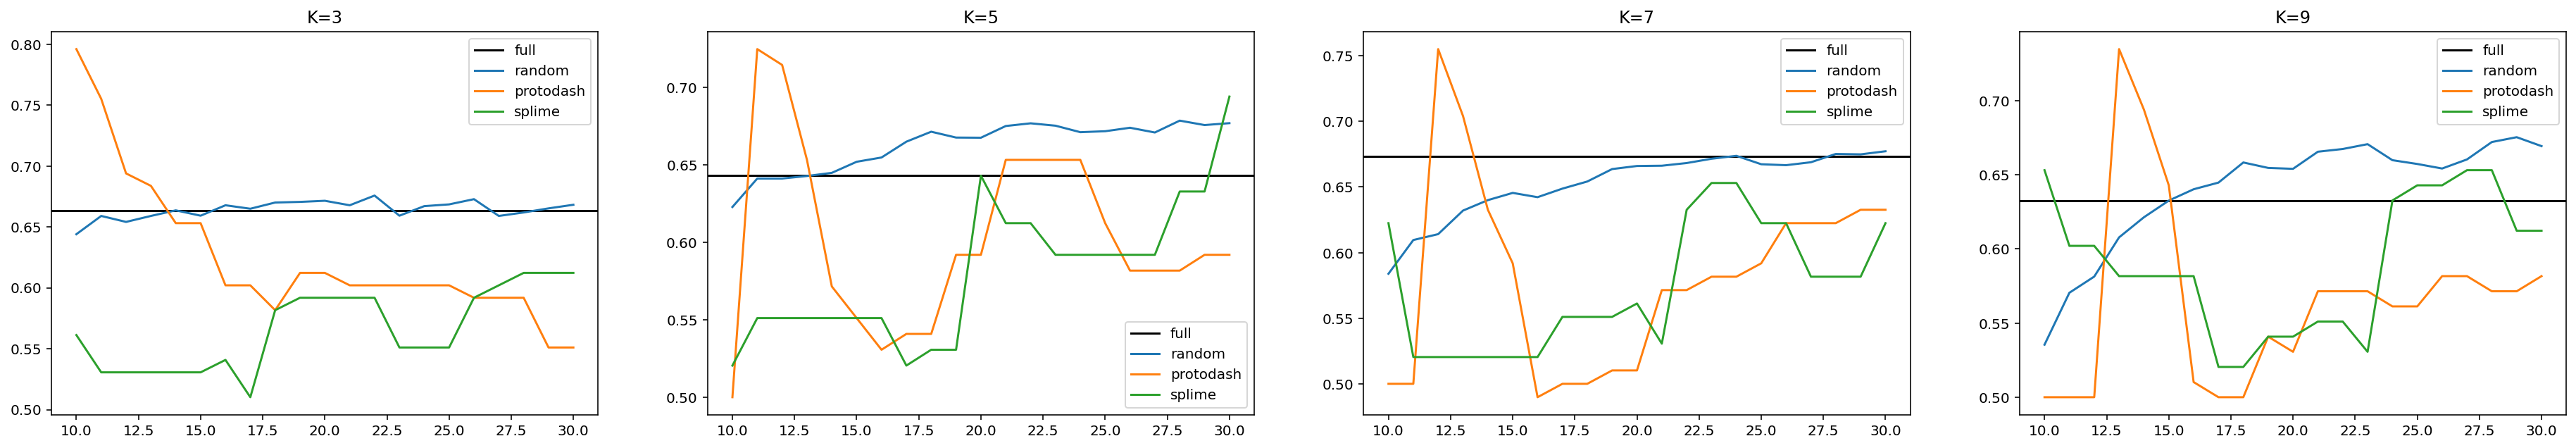

In [138]:
# fig, ax = plt.subplots(1, len(k_range), figsize=(32, 5))
# for k in range(len(k_range)):
#     ax[k].axhline(f_scores[k], c='black')
#     ax[k].plot(m_range, r_scores[k])
#     ax[k].plot(m_range, p_scores[k])
#     ax[k].plot(m_range, s_scores[k])
#     ax[k].legend(['full', 'random', 'protodash', 'splime'])
#     ax[k].legend(['full', 'random', 'protodash'])
#     ax[k].set_title('K={}'.format(k_range[k]))

In [142]:
train_path = 'data/prostatex/train_bal_findings_emb10.pkl'
valid_path = 'data/prostatex/valid_bal_findings_emb10.pkl'
f_train, _, y_train, X_train, _ = pickle.load(open(train_path, "rb"))
f_valid, _, y_valid, X_valid, _ = pickle.load(open(valid_path, "rb"))
data = X_train, y_train, X_valid, y_valid
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
print(lr.score(X_valid, y_valid))
coef = np.vstack([lr.coef_, -lr.coef_])
W = extract_W_multiclass(coef, X_train, y_train, coo=False)
k_range = [3, 5, 7, 9]
m_range = range(10, 31)
f_scores = []
for k in k_range:
    full = KNeighborsClassifier(n_neighbors=k)
    full.fit(X_train, y_train)
    f_scores.append(full.score(X_valid, y_valid))
f_scores = np.array(f_scores)

0.6020408163265306


In [99]:
p_idss = {}
s_idss = {}

X_train, y_train, X_valid, y_valid = data
for m in m_range:
    protodash = ProtodashExplainer()
    _, index, _ = protodash.explain(X_train, X_train, m=m)
    p_idss[m] = index
    budget = [(m+1)//2, m//2]
    sp_results, current_obj, importance = gready_sp_multiclass(W, budget, y_train, 100)
    index = sp_results[0] + sp_results[1]
    s_idss[m] = index

In [101]:
p_scores = []
s_scores = []
for k in k_range:
    for m in m_range:
        p_scores.append(get_knn_score(k, data, p_idss[m]))
        s_scores.append(get_knn_score(k, data, s_idss[m]))
p_scores = np.array(p_scores).reshape(len(k_range), len(m_range))
s_scores = np.array(s_scores).reshape(len(k_range), len(m_range))

In [102]:
r_scores = []
for k in k_range:
    for m in m_range:
        np.random.seed(42)
        scores = []
        for i in range(100):
            index = np.random.choice(range(len(X_train)), m)
            scores.append(get_knn_score(k, data, index))
        r_scores.append(np.mean(scores))
r_scores = np.array(r_scores).reshape(len(k_range), len(m_range))

In [103]:
emb10_bal = (f_scores, r_scores, p_scores, s_scores)
path = "emb10_bal_scores_v2.pkl"
pickle.dump(emb10_bal, open(path, "wb"))

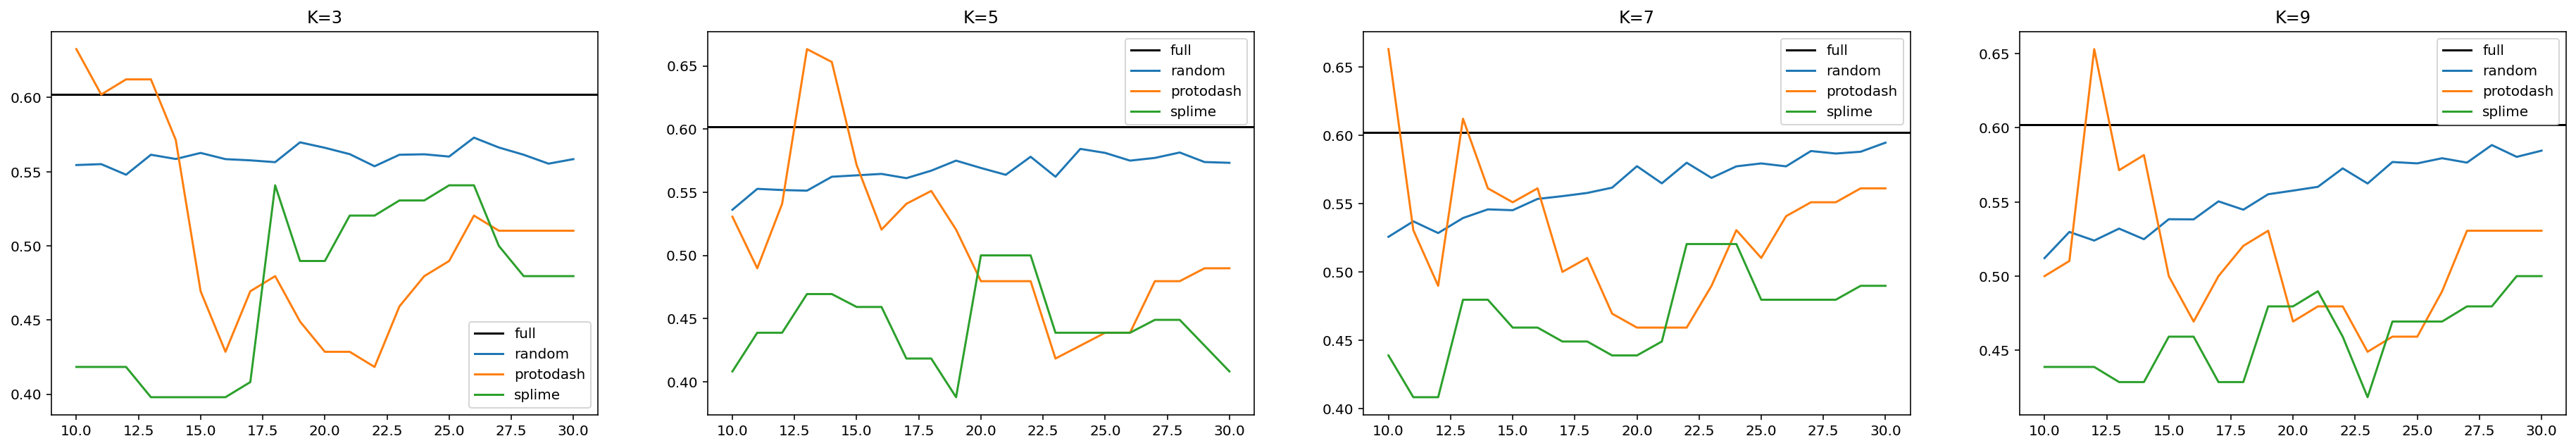

In [106]:
fig, ax = plt.subplots(1, len(k_range), figsize=(32, 5))
for k in range(len(k_range)):
    ax[k].axhline(f_scores[k], c='black')
    ax[k].plot(m_range, r_scores[k])
    ax[k].plot(m_range, p_scores[k])
    ax[k].plot(m_range, s_scores[k])
    ax[k].legend(['full', 'random', 'protodash', 'splime'])
    ax[k].set_title('K={}'.format(k_range[k]))

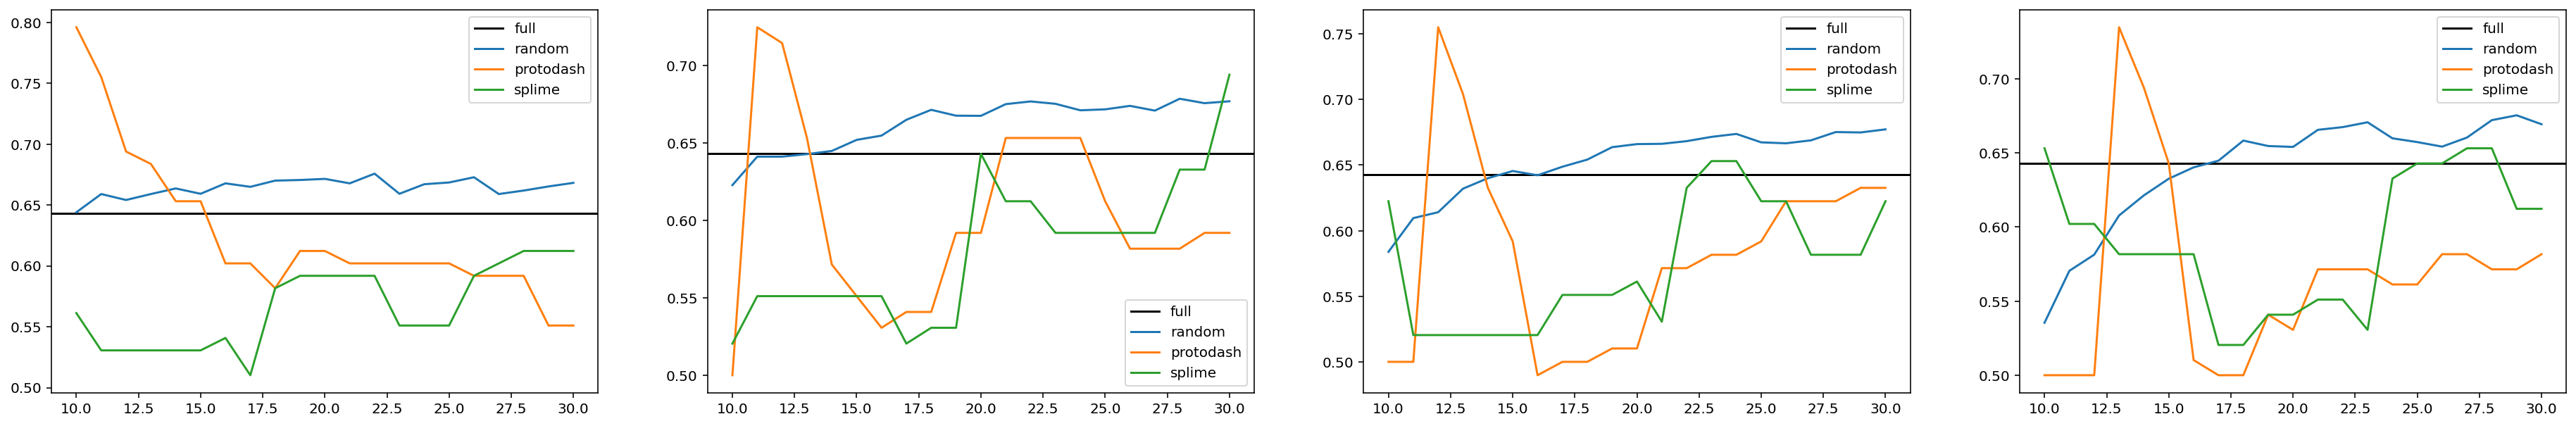

In [ ]:
fig, ax = plt.subplots(1, len(k_range), figsize=(32, 5))
for k in range(len(k_range)):
    ax[k].axhline(f_scores[k], c='black')
    ax[k].plot(m_range, r_scores[k])
    ax[k].plot(m_range, p_scores[k])
    ax[k].plot(m_range, s_scores[k])
    ax[k].legend(['full', 'random', 'protodash', 'splime'])